In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Set device
device = "cuda:0"

### --- SHARED COMPONENTS (Scheduler & U-Net) --- ###

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    mean = sqrt_alphas_cumprod_t * x_0
    variance = sqrt_one_minus_alphas_cumprod_t * noise
    return mean + variance, noise

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bn2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [7]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [8]:
# Hyperparameters
IMG_SIZE = 32
BATCH_SIZE = 512
EPOCHS = 100 # Reduced for demonstration
LR = 0.001
TOTAL_TIMESTEPS = 1000 # Total diffusion steps for training

# --- Prepare Diffusion Constants ---
betas = linear_beta_schedule(timesteps=TOTAL_TIMESTEPS)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# --- Load Data ---
transforms_mnist = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms_mnist)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# --- Initialize and Train Model ---
model = Unet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
loss_history = []

--- Training Unconditional DDPM (for DDIM Sampling) ---


Epoch 1: 100%|██████████| 117/117 [00:31<00:00,  3.68it/s]


Epoch 1 Average Loss: 0.1085


Epoch 2: 100%|██████████| 117/117 [00:31<00:00,  3.76it/s]


Epoch 2 Average Loss: 0.0363


Epoch 3: 100%|██████████| 117/117 [00:31<00:00,  3.75it/s]


Epoch 3 Average Loss: 0.0287


Epoch 4: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 4 Average Loss: 0.0259


Epoch 5: 100%|██████████| 117/117 [00:31<00:00,  3.68it/s]


Epoch 5 Average Loss: 0.0246


Epoch 6: 100%|██████████| 117/117 [00:31<00:00,  3.71it/s]


Epoch 6 Average Loss: 0.0235


Epoch 7: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 7 Average Loss: 0.0229


Epoch 8: 100%|██████████| 117/117 [00:31<00:00,  3.70it/s]


Epoch 8 Average Loss: 0.0221


Epoch 9: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 9 Average Loss: 0.0219


Epoch 10: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 10 Average Loss: 0.0214


Epoch 11: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 11 Average Loss: 0.0211


Epoch 12: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 12 Average Loss: 0.0205


Epoch 13: 100%|██████████| 117/117 [00:31<00:00,  3.71it/s]


Epoch 13 Average Loss: 0.0204


Epoch 14: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 14 Average Loss: 0.0199


Epoch 15: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 15 Average Loss: 0.0197


Epoch 16: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 16 Average Loss: 0.0199


Epoch 17: 100%|██████████| 117/117 [00:31<00:00,  3.70it/s]


Epoch 17 Average Loss: 0.0197


Epoch 18: 100%|██████████| 117/117 [00:31<00:00,  3.75it/s]


Epoch 18 Average Loss: 0.0192


Epoch 19: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 19 Average Loss: 0.0194


Epoch 20: 100%|██████████| 117/117 [00:31<00:00,  3.71it/s]


Epoch 20 Average Loss: 0.0189


Epoch 21: 100%|██████████| 117/117 [00:31<00:00,  3.70it/s]


Epoch 21 Average Loss: 0.0190


Epoch 22: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 22 Average Loss: 0.0190


Epoch 23: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 23 Average Loss: 0.0186


Epoch 24: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 24 Average Loss: 0.0187


Epoch 25: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 25 Average Loss: 0.0187


Epoch 26: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 26 Average Loss: 0.0182


Epoch 27: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 27 Average Loss: 0.0182


Epoch 28: 100%|██████████| 117/117 [00:31<00:00,  3.75it/s]


Epoch 28 Average Loss: 0.0182


Epoch 29: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 29 Average Loss: 0.0182


Epoch 30: 100%|██████████| 117/117 [00:31<00:00,  3.75it/s]


Epoch 30 Average Loss: 0.0184


Epoch 31: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 31 Average Loss: 0.0182


Epoch 32: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 32 Average Loss: 0.0180


Epoch 33: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 33 Average Loss: 0.0178


Epoch 34: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 34 Average Loss: 0.0178


Epoch 35: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 35 Average Loss: 0.0177


Epoch 36: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 36 Average Loss: 0.0175


Epoch 37: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 37 Average Loss: 0.0176


Epoch 38: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 38 Average Loss: 0.0178


Epoch 39: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 39 Average Loss: 0.0176


Epoch 40: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 40 Average Loss: 0.0177


Epoch 41: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 41 Average Loss: 0.0174


Epoch 42: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 42 Average Loss: 0.0176


Epoch 43: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 43 Average Loss: 0.0173


Epoch 44: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 44 Average Loss: 0.0174


Epoch 45: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 45 Average Loss: 0.0171


Epoch 46: 100%|██████████| 117/117 [00:31<00:00,  3.75it/s]


Epoch 46 Average Loss: 0.0173


Epoch 47: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 47 Average Loss: 0.0173


Epoch 48: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 48 Average Loss: 0.0173


Epoch 49: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 49 Average Loss: 0.0173


Epoch 50: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 50 Average Loss: 0.0171


Epoch 51: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 51 Average Loss: 0.0173


Epoch 52: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 52 Average Loss: 0.0172


Epoch 53: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 53 Average Loss: 0.0174


Epoch 54: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 54 Average Loss: 0.0169


Epoch 55: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 55 Average Loss: 0.0171


Epoch 56: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 56 Average Loss: 0.0170


Epoch 57: 100%|██████████| 117/117 [00:31<00:00,  3.75it/s]


Epoch 57 Average Loss: 0.0171


Epoch 58: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 58 Average Loss: 0.0169


Epoch 59: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 59 Average Loss: 0.0169


Epoch 60: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 60 Average Loss: 0.0169


Epoch 61: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 61 Average Loss: 0.0170


Epoch 62: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 62 Average Loss: 0.0170


Epoch 63: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 63 Average Loss: 0.0170


Epoch 64: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 64 Average Loss: 0.0171


Epoch 65: 100%|██████████| 117/117 [00:31<00:00,  3.71it/s]


Epoch 65 Average Loss: 0.0169


Epoch 66: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 66 Average Loss: 0.0168


Epoch 67: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 67 Average Loss: 0.0168


Epoch 68: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 68 Average Loss: 0.0168


Epoch 69: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 69 Average Loss: 0.0166


Epoch 70: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 70 Average Loss: 0.0169


Epoch 71: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 71 Average Loss: 0.0164


Epoch 72: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 72 Average Loss: 0.0169


Epoch 73: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 73 Average Loss: 0.0167


Epoch 74: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 74 Average Loss: 0.0166


Epoch 75: 100%|██████████| 117/117 [00:31<00:00,  3.75it/s]


Epoch 75 Average Loss: 0.0165


Epoch 76: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 76 Average Loss: 0.0165


Epoch 77: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 77 Average Loss: 0.0166


Epoch 78: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 78 Average Loss: 0.0166


Epoch 79: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 79 Average Loss: 0.0167


Epoch 80: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 80 Average Loss: 0.0166


Epoch 81: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 81 Average Loss: 0.0163


Epoch 82: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 82 Average Loss: 0.0165


Epoch 83: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 83 Average Loss: 0.0168


Epoch 84: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 84 Average Loss: 0.0165


Epoch 85: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 85 Average Loss: 0.0165


Epoch 86: 100%|██████████| 117/117 [00:31<00:00,  3.74it/s]


Epoch 86 Average Loss: 0.0166


Epoch 87: 100%|██████████| 117/117 [00:31<00:00,  3.70it/s]


Epoch 87 Average Loss: 0.0165


Epoch 88: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 88 Average Loss: 0.0164


Epoch 89: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 89 Average Loss: 0.0163


Epoch 90: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 90 Average Loss: 0.0166


Epoch 91: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 91 Average Loss: 0.0164


Epoch 92: 100%|██████████| 117/117 [00:31<00:00,  3.71it/s]


Epoch 92 Average Loss: 0.0164


Epoch 93: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 93 Average Loss: 0.0164


Epoch 94: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 94 Average Loss: 0.0164


Epoch 95: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 95 Average Loss: 0.0164


Epoch 96: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]


Epoch 96 Average Loss: 0.0161


Epoch 97: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 97 Average Loss: 0.0164


Epoch 98: 100%|██████████| 117/117 [00:31<00:00,  3.71it/s]


Epoch 98 Average Loss: 0.0162


Epoch 99: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s]


Epoch 99 Average Loss: 0.0163


Epoch 100: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]

Epoch 100 Average Loss: 0.0165


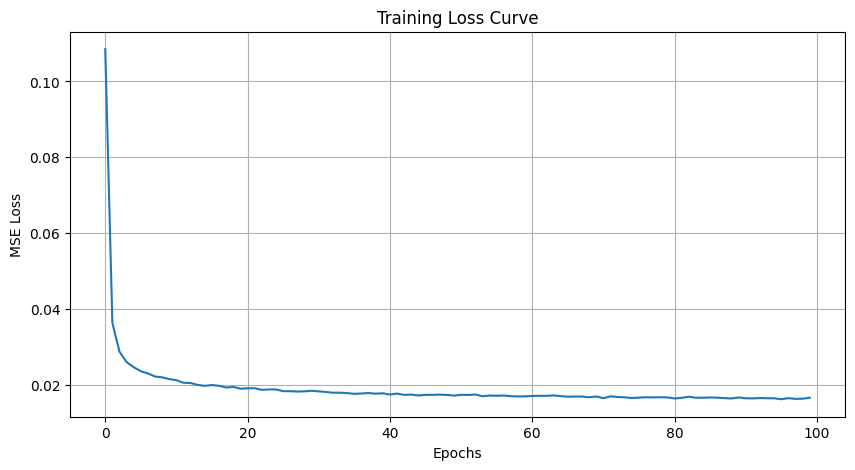

In [9]:
print("--- Training Unconditional DDPM (for DDIM Sampling) ---")
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for step, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        optimizer.zero_grad()
        x0 = images.to(device)
        t = torch.randint(0, TOTAL_TIMESTEPS, (x0.shape[0],), device=device).long()
        xt, noise_target = forward_diffusion_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
        predicted_noise = model(xt, t)
        loss = criterion(noise_target, predicted_noise)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

# --- Plot Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

# ==========================================================
# --- End of Training ---
# ==========================================================


--- Starting DDIM Sampling with 30 steps (eta=0.0) ---


DDIM Sampling: 100%|██████████| 30/30 [00:00<00:00, 112.33it/s]


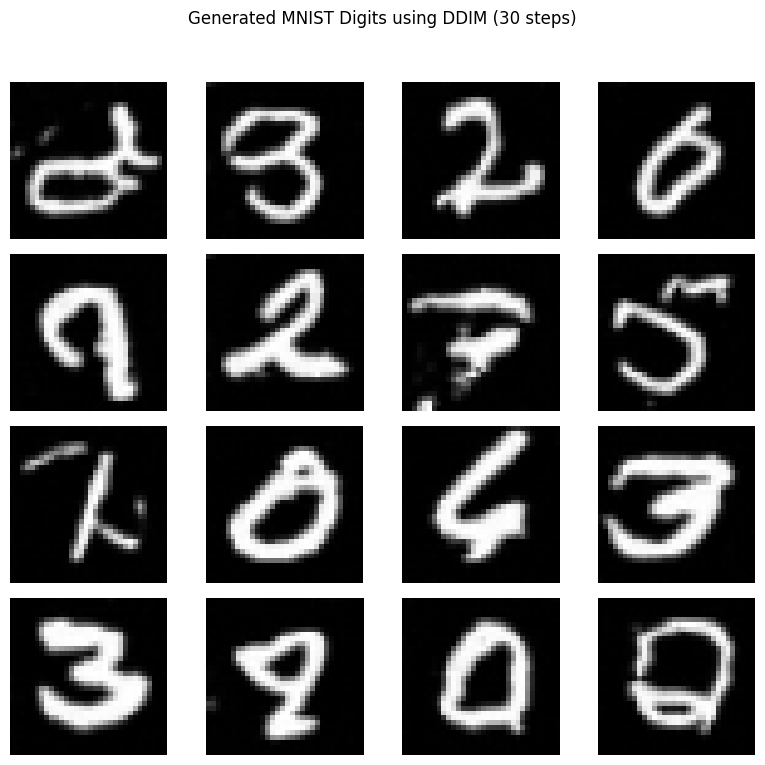

In [10]:
### --- DDIM Sampling Function --- ###

@torch.no_grad()
def ddim_sample(
    num_images=16,
    sampling_timesteps=30,  # number of DDIM steps (≪ TOTAL_TIMESTEPS)
    eta=0.0                 # η=0 → deterministic; η=1 → full DDPM‐like stochasticity
):
    """
    Generates images using the DDIM sampling procedure.
    """
    # Log the start of sampling
    print(f"\n--- Starting DDIM Sampling with {sampling_timesteps} steps (eta={eta}) ---")
    # Put model in eval mode (disable dropout/batchnorm updates)
    model.eval()

    # 1) Build a shortened timetable of indices from T-1 down to 0
    #    torch.linspace(-1, TOTAL_TIMESTEPS-1, steps=…) picks sampling_timesteps+1 points
    times = torch.linspace(-1, TOTAL_TIMESTEPS - 1, steps=sampling_timesteps + 1)
    #    Convert to int and reverse so we go from high→low: e.g. [T-1, T-1-Δ, …, 0, -1]
    times = list(reversed(times.int().tolist()))
    #    Pair each adjacent time: [(t_0, t_1), (t_1, t_2), …], representing (current, next)
    time_pairs = list(zip(times[:-1], times[1:]))  # e.g., (300, 280), (280, 260), …

    # 2) Initialize x_T ∼ N(0, I)
    img = torch.randn((num_images, 1, IMG_SIZE, IMG_SIZE), device=device)

    # 3) Loop over each (time, time_next) to step down the noise levels
    for time, time_next in tqdm(time_pairs, desc="DDIM Sampling"):
        # Create a tensor of the current timestep index for the whole batch
        time_cond = torch.full((num_images,), time, device=device, dtype=torch.long)

        # --- Step 1: Predict noise ε_θ(x_t, t) ---
        pred_noise = model(img, time_cond)

        # --- Step 2: Compute ᾱ_t and ᾱ_{t_next} from the stored cumulative-products ---
        # alpha_bar_t = ᾱ_t = ∏_{s=1}^t (1 − β_s)
        alpha_bar_t = alphas_cumprod[time]
        # For the final step (time_next = -1) we set ᾱ_{-1} = 1
        alpha_bar_t_next = alphas_cumprod[time_next] if time_next >= 0 else torch.tensor(1.0, device=device)
        # α_t = ᾱ_t / ᾱ_{t_next}  (this yields the non‐cumulative α_t when steps are skipped)
        alpha_t = alpha_bar_t / alpha_bar_t_next

        # --- Step 3: Predict the original x₀ from x_t ---
        # Formula: x̂₀ = (x_t − sqrt(1−ᾱ_t)⋅ε_pred) / sqrt(ᾱ_t)
        pred_x0 = (img - torch.sqrt(1.0 - alpha_bar_t) * pred_noise) / torch.sqrt(alpha_bar_t)
        # Clip to [−1,1] to keep predictions bounded
        pred_x0 = torch.clamp(pred_x0, -1.0, 1.0)

        # --- Step 4: Compute the “direction” term pointing to x_t ---
        # dir_xt = sqrt(1 − ᾱ_{t_next}) ⋅ ε_pred
        dir_xt = torch.sqrt(1.0 - alpha_bar_t_next) * pred_noise

        # --- Step 5: Compute the noise scale σ_t controlled by η ---
        # σ_t = η · sqrt( ((1 − ᾱ_t/ᾱ_{t_next})·(1 − ᾱ_{t_next})) / (1 − ᾱ_t) )
        sigma = eta * torch.sqrt(
            (1.0 - alpha_bar_t / alpha_bar_t_next)
            * (1.0 - alpha_bar_t_next)
            / (1.0 - alpha_bar_t)
        )

        # --- Step 6: Sample fresh noise z ∼ N(0,I) if η>0, else zeros for deterministic path ---
        noise = torch.randn_like(img) if eta > 0 else torch.zeros_like(img)

        # --- Step 7: Combine terms to form x_{t_next} ---
        # Full DDIM update: x_{t_next} = sqrt(ᾱ_{t_next})·x̂₀ + dir_xt + σ_t·z
        img = torch.sqrt(alpha_bar_t_next) * pred_x0 + dir_xt + sigma * noise

    # Restore model to train mode
    model.train()

    # 4) Map images from normalized [−1,1] back to [0,1] for display
    img = (img + 1) * 0.5
    img = img.clamp(0, 1)
    return img
# --- Generate and Plot Images using DDIM ---
# Note how we use only 50 steps for sampling, even though the model was trained for 300!
generated_images = ddim_sample(num_images=16, sampling_timesteps=30, eta=0.0)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Generated MNIST Digits using DDIM ({30} steps)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Optional: Compare with DDPM-like sampling ---
# We can recover the DDPM behavior by setting eta=1.0 and using all timesteps.
# This would be much slower.
# generated_images_ddpm_like = ddim_sample(num_images=16, sampling_timesteps=TOTAL_TIMESTEPS, eta=1.0)